In [1]:
import os, sys
import rasterio
from rasterio.mask import mask
import numpy as np
from matplotlib import pyplot as plt
import glob
from xml.dom import minidom
import fiona
from shapely.geometry import mapping, shape
import scipy.misc as misc
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [13]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)

# function to return collection dates from Planet MultiSpectral image metadata
def getDates_planet(xml_file):

    xmldoc = minidom.parse(xml_file)
    date_node = xmldoc.getElementsByTagName("eop:acquisitionDate")
    date_str = str(date_node[0].firstChild.nodeValue)
    acq_date_yyyymmdd = date_str.split('T')[0]        
    
    return acq_date_yyyymmdd

# function to return correction coefficients from Planet MultiSpectral image metadata
def getCorrCoefs_planet(xml_file):

    xmldoc = minidom.parse(xml_file)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
            
    return coeffs

# function to extract image patch
def getImagePatch_planet(imfile, poly):
    
    try:
        with rasterio.open(imfile, 'r') as src:
            arr,_ = mask(src, [poly], crop=True)

        if arr.sum() != 0.:
            return arr
        else:
            return 0
        
    except:
        return 0

# function return geometries as geoJSON
def getGeometries_planet(shpfile):
    
    with fiona.open(shpfile, "r") as shapefile:
        geoms = [feature["geometry"] for feature in shapefile]
        
    return geoms


def getMeansBand(arr, nbands):
    
    print(arr.shape)
    res=[]
    for i in range(nbands):
        res.append(arr[i,:,:].mean())
    
    return res

def getSTDband(arr, nbands):
    
    res=[]
    for i in range(nbands):
        res.append(arr[i,:,:].std())
    
    return res

def cor_ms(ms_temp, cf_arr):
    # extract the band means per patch
    ms_band1 = [b[0,:,:] for b in ms_temp]
    ms_band2 = [b[1,:,:] for b in ms_temp]
    ms_band3 = [b[2,:,:] for b in ms_temp]
    ms_band4 = [b[3,:,:] for b in ms_temp]
    
    # correct the ms images to TOA reflectance
    ms_band1_cor = [cf[0] * mn for cf,mn in zip(cf_arr, ms_band1)]
    ms_band2_cor = [cf[1] * mn for cf,mn in zip(cf_arr, ms_band2)]
    ms_band3_cor = [cf[2] * mn for cf,mn in zip(cf_arr, ms_band3)]
    ms_band4_cor = [cf[3] * mn for cf,mn in zip(cf_arr, ms_band4)]
    
    res = []
    for i in range(len(ms_band1_cor)):
        res.append(np.rollaxis(np.dstack((ms_band1_cor[i], ms_band2_cor[i], ms_band3_cor[i], ms_band4_cor[i])),2,0))
    
    return res
    
def meanIntensityOverGeometry_simple_Landsat(bandlist, poly):
    
    # SR scale factor
    sr_scale = 10000.
    
    # get the band patches. should be 4 of size 1xrowsxcols items, [blue, green, red, nir]
    band_patches = [getImagePatch_planet(im, poly) for im in bandlist]
    #band_temp = [np.ma.masked_equal(arr, -9999.)/sr_scale for arr in band_patches if type(arr) is np.ma.core.MaskedArray]
    band_temp = [np.ma.masked_equal(arr, -9999.)/sr_scale for arr in band_patches]
    #band_means = [getMeansBand(im,1) for im in band_temp]
    band_means = [im.mean() for im in band_temp]
    band_std = [im.std() for im in band_temp]
    
    res = {}
    res['sr_means'] = band_means
    res['numpixels'] = band_temp[0].count()
    res['sr_std'] = band_std
    
    #band_temp = [np.ma.masked_equal(arr, -9999.) for arr in band_temp]
    res['image'] = np.ma.array([b.squeeze() for b in band_temp])
    return res
    

# define function which process the planet images within a specified geometry
def meanIntensityOverGeometry_simple(im, xml, poly):
    
    # SR scale factor
    sr_scale = 10000.    
    
    #ms_patch = getImagePatch_planet(im, poly)
    sr_patch = getImagePatch_planet(im, poly) #/ sr_scale 
    
    coeffs = getCorrCoefs_planet(xml)
    date_s = getDates_planet(xml)
    
    #ms_patch_temp = [ms_patches[i] for i in xml_inds]
    #ms_temp = [np.ma.masked_equal(arr, 0.0) for arr in ms_patch_temp if type(arr) is np.ma.core.MaskedArray]
    #ms_cor = cor_ms(ms_temp, cf_arr) # correct the MS imagery to TOA reflectance
    #ms_means = [getMeansBand(arr,4) for arr in ms_cor]

    #sr_patch_temp = [sr_patches[i] for i in xml_inds]
    #sr_temp = [np.ma.masked_equal(arr, 0.0) for arr in sr_patch_temp if type(arr) is np.ma.core.MaskedArray]
    sr_temp = np.ma.masked_equal(sr_patch, 0.0) / sr_scale
    sr_means = getMeansBand(sr_temp,4)
    sr_stds = getSTDband(sr_temp, 4)
    
    
    
    # extract the band means per patch
    #ms_band1_mean = [b[0] for b in ms_means]
    #ms_band2_mean = [b[1] for b in ms_means]
    #ms_band3_mean = [b[2] for b in ms_means]
    #ms_band4_mean = [b[3] for b in ms_means]

    
    sr_band1_mean = sr_means[0] #/sr_scale 
    sr_band2_mean = sr_means[1] #/sr_scale 
    sr_band3_mean = sr_means[2] #/sr_scale 
    sr_band4_mean = sr_means[3] #/sr_scale
    
    sr_band1_std = sr_stds[0]
    sr_band2_std = sr_stds[1]
    sr_band3_std = sr_stds[2]
    sr_band4_std = sr_stds[3]
    
    # put the dates in a usable list corresponding to only overlapping images
    #date_arr = [dates[i] for i in xml_inds]

    res = {}
    #res['ms_means'] = [ms_band1_means, ms_band2_means, ms_band3_means, ms_band4_means]
    res['sr_means'] = [sr_band1_mean, sr_band2_mean, sr_band3_mean, sr_band4_mean]
    res['sr_std'] = [sr_band1_std, sr_band2_std, sr_band3_std, sr_band4_std]
    res['dates'] = date_s
    res['numpixels'] = sr_temp[0,:,:].count()
    res['image'] = sr_temp
#     res['ms_std'] = [ms_band1_std_cor, ms_band2_std_cor, ms_band3_std_cor, ms_band4_std_cor]
#     res['sr_std'] = [sr_band1_std, sr_band2_std, sr_band3_std, sr_band4_std]
    return res

def returnSamples(pl_imArr, oli_imArr, method='direct'):
    '''this function returns the planet samples within a landsat pixel.
        The list of methods is to account for how the landsat pixel is sampled for each set of planet pixels.
        Currently, 'direct' is the only one and assigns the same landsat pixel for each planet pixel in the set'''
    
    # get the rows and columns of the landsat data
    oli_rows, oli_cols = oli_imArr.shape
    
    # get the rows and columns of the planet data
    planet_rows, planet_cols = pl_imArr.shape
    
    # get the row/column factors for how many planet pixels will fit in a landsat pixel
    row_fact = int(np.floor(planet_rows/oli_rows))
    col_fact = int(np.floor(planet_cols/oli_cols))
    
    # it is not necessarily an even number given the spatial extraction, so add in the modulus
    row_mod = planet_rows%oli_rows
    col_mod = planet_cols%oli_cols
    
    # get the ranges of pixels to grab from planet
    row_sets = np.arange(0,planet_rows, row_fact) + row_mod
    col_sets = np.arange(0, planet_cols, col_fact) + col_mod
    
    # sample via landsat
    samples = []
    for r in range(oli_rows-1):
        for c in range(oli_cols-1):
            
            # get the landsat pixel
            oli_pix_val = oli_imArr[r,c]
            
            # get the pixels from planet if the pixel is not 0 or -9999
            if oli_pix_val is not np.ma.masked: # set the condition later
                pl_row_start = row_sets[r]
                pl_row_end = row_sets[r+1]
                pl_col_start = col_sets[c]
                pl_col_end = col_sets[c+1]
                pl_pix = pl_imArr[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                
                oli_pix = np.ones(pl_pix.shape)*oli_pix_val
                samples.append(np.vstack((oli_pix, pl_pix)))
    
    return samples

def returnSamplesMeanStd(pl_imArr, oli_imArr, method='direct'):
    '''this function returns the planet samples within a landsat pixel.
        The list of methods is to account for how the landsat pixel is sampled for each set of planet pixels.
        Currently, 'direct' is the only one and assigns the same landsat pixel for each planet pixel in the set'''
    
    # get the rows and columns of the landsat data
    oli_rows, oli_cols = oli_imArr.shape
    
    # get the rows and columns of the planet data
    planet_rows, planet_cols = pl_imArr.shape
    
    # get the row/column factors for how many planet pixels will fit in a landsat pixel
    row_fact = int(np.floor(planet_rows/oli_rows))
    col_fact = int(np.floor(planet_cols/oli_cols))
    
    # it is not necessarily an even number given the spatial extraction, so add in the modulus
    row_mod = planet_rows%oli_rows
    col_mod = planet_cols%oli_cols
    
    # get the ranges of pixels to grab from planet
    row_sets = np.arange(0,planet_rows, row_fact) + row_mod
    col_sets = np.arange(0, planet_cols, col_fact) + col_mod
    
    # sample via landsat
    samples = []
    for r in range(oli_rows-1):
        for c in range(oli_cols-1):
            
            # get the landsat pixel
            oli_pix_val = oli_imArr[r,c]
            
            # get the pixels from planet if the pixel is not 0 or -9999
            if oli_pix_val is not np.ma.masked: # set the condition later
                pl_row_start = row_sets[r]
                pl_row_end = row_sets[r+1]
                pl_col_start = col_sets[c]
                pl_col_end = col_sets[c+1]
                pl_pix = pl_imArr[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                pl_pix_mean = np.mean(pl_pix)
                pl_pix_std = np.std(pl_pix)
                pl_pix_max = np.max(pl_pix)
                pl_pix_min = np.min(pl_pix)
                
                
                samples.append(np.array([[oli_pix_val], [pl_pix_mean], [pl_pix_std], [pl_pix_max - pl_pix_min]]))
    
    return samples

def returnSamplesMeanStd_ndvi(pl_imArr_red, pl_imArr_nir, oli_imArr_red, oli_imArr_nir, method='direct'):
    '''this function returns the planet samples within a landsat pixel.
        The list of methods is to account for how the landsat pixel is sampled for each set of planet pixels.
        Currently, 'direct' is the only one and assigns the same landsat pixel for each planet pixel in the set'''
    
    # get the rows and columns of the landsat data
    oli_rows, oli_cols = oli_imArr_red.shape
    
    # get the rows and columns of the planet data
    planet_rows, planet_cols = pl_imArr_red.shape
    
    # get the row/column factors for how many planet pixels will fit in a landsat pixel
    row_fact = int(np.floor(planet_rows/oli_rows))
    col_fact = int(np.floor(planet_cols/oli_cols))
    
    # it is not necessarily an even number given the spatial extraction, so add in the modulus
    row_mod = planet_rows%oli_rows
    col_mod = planet_cols%oli_cols
    
    # get the ranges of pixels to grab from planet
    row_sets = np.arange(0,planet_rows, row_fact) + row_mod
    col_sets = np.arange(0, planet_cols, col_fact) + col_mod
    
    # sample via landsat
    samples = []
    for r in range(oli_rows-1):
        for c in range(oli_cols-1):
            
            # get the landsat pixel
            oli_pix_val_red = oli_imArr_red[r,c]
            oli_pix_val_nir = oli_imArr_nir[r,c]
            
            # get the pixels from planet if the pixel is not 0 or -9999
            if oli_pix_val_red is not np.ma.masked: 
                pl_row_start = row_sets[r]
                pl_row_end = row_sets[r+1]
                pl_col_start = col_sets[c]
                pl_col_end = col_sets[c+1]
                
                pl_pix_red = pl_imArr_red[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                pl_pix_nir = pl_imArr_nir[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                pl_ndvi = (pl_pix_nir - pl_pix_red) / (pl_pix_nir + pl_pix_red)
                pl_ndvi_mean = np.mean(pl_ndvi)
                pl_ndvi_std = np.std(pl_ndvi)
                pl_ndvi_max = np.max(pl_ndvi)
                pl_ndvi_min = np.min(pl_ndvi)
                
                oli_ndvi = (oli_pix_val_nir - oli_pix_val_red) / (oli_pix_val_nir + oli_pix_val_red)
                
                
                samples.append(np.array([[oli_ndvi], [pl_ndvi_mean], [pl_ndvi_std], [pl_ndvi_max - pl_ndvi_min]]))
    
    return samples

In [16]:
# extract the field plot locations
home_dir = '/data/playa_comparison/planet' # r"C:\Projects\RD\planet\sample_order"
shp = r"C:\Projects\RD\planet\playa_site\shp\playa_aoi.shp" # r"C:\Projects\rd\planet\proj_cc_sites.shp"
polys = getGeometries_planet(shp)

# set up the planet file names for time series over playa site
planet_tifs = [
    '20170810_174556_1032_3B_AnalyticMS_SR.tif',
    '20170810_174324_1022_3B_AnalyticMS_SR.tif',
    '20170805_174520_0f38_3B_AnalyticMS_SR.tif',
    '20170803_174404_101d_3B_AnalyticMS_SR.tif'
]

planet_dirs = [
    '20170810_174556_1032',
    '20170810_174324_1022',
    '20170805_174520_0f38',
    '20170803_174404_101d'
]

planet_home_dir = r'C:\Projects\RD\planet\playa_site'

# iterate through them all and store information
pl_dates = []
pl_images = []
pl_xml = []
for i, folder in enumerate(planet_dirs):
    planet_image = os.path.join(planet_home_dir, folder, planet_tifs[i])
    planet_xml = planet_image.replace('MS_SR.tif', 'MS_metadata.xml')
    planet_date = getDates_planet(planet_xml)
    planet_cc = getCorrCoefs_planet(planet_xml)
    
    # keep track of the metadata and image filename. TODO: get more metadata, like sensor angle, id, etc.
    pl_dates.append(planet_date)
    pl_xml.append(planet_xml)
    pl_images.append(planet_image)

# landsat info
# set up the filenames for the landsat image
landsat_dir = r"C:\Projects\RD\planet\playa_site\LC080400332017080501T1-SC20180215155348"
landsat_base = os.path.join(landsat_dir, 'LC08_L1TP_040033_20170805_20170812_01_T1_sr_')

# construct landsat filenames
bands = ['band2', 'band3', 'band4', 'band5'] # [blue, green, red, nir]
landsat_bandfiles = ['{}{}.tif'.format(landsat_base, b) for b in bands]

In [31]:
# get the centroids of the polygons and buffer them
# convert to centroids
centroids = [shape(p).centroid for p in polys]

# buffer out buffer_distance*2 meters total. square capping.
buffer_distance = 300.
buffer_p = [c.buffer(buffer_distance, cap_style=3) for c in centroids]

# convert them back to geojson
buffers = [mapping(b) for b in buffer_p]

## iterate over the geometries (for playa site, should only be one geometry)
## store the data for each planet image, so this is actually the iterable
pl_samples, blue_samples, green_samples, red_samples, nir_samples, ndvi_samples, max_refl, min_refl = [],[],[],[],[],[],[],[]
for planet_image in pl_images:

    # read the planet image over the buffered geometries
    planet = [meanIntensityOverGeometry_simple(planet_image, pl_xml[i], p) for p in buffers]
    pl_samples.append(planet[plot_ind])
    
    # read the landsat 8 OLI image over the buffered geometries
    oli = [meanIntensityOverGeometry_simple_Landsat(landsat_bandfiles, p) for p in buffers]


    ## get the pixel samples for each band for a given plot *within the corresponding landsat pixel*
    plot_ind = 0
    #blue_samples = returnSamplesMeanStd(planet[plot_ind]['image'][0,:,:], oli[plot_ind]['image'][0,:,:])
    #green_samples = returnSamplesMeanStd(planet[plot_ind]['image'][1,:,:], oli[plot_ind]['image'][1,:,:])
    #red_samples = returnSamplesMeanStd(planet[plot_ind]['image'][2,:,:], oli[plot_ind]['image'][2,:,:])
    #nir_samples = returnSamplesMeanStd(planet[plot_ind]['image'][3,:,:], oli[plot_ind]['image'][3,:,:])

    #max_refl = np.max(np.array((blue_samples, green_samples, red_samples, nir_samples)))
    #min_refl = np.min(np.array((blue_samples, green_samples, red_samples, nir_samples)))
    
    blue_samples.append(returnSamplesMeanStd(planet[plot_ind]['image'][0,:,:], oli[plot_ind]['image'][0,:,:]))
    green_samples.append(returnSamplesMeanStd(planet[plot_ind]['image'][1,:,:], oli[plot_ind]['image'][1,:,:]))
    red_samples.append(returnSamplesMeanStd(planet[plot_ind]['image'][2,:,:], oli[plot_ind]['image'][2,:,:]))
    nir_samples.append(returnSamplesMeanStd(planet[plot_ind]['image'][3,:,:], oli[plot_ind]['image'][3,:,:]))

    max_refl.append(np.max(np.array((blue_samples, green_samples, red_samples, nir_samples))))
    min_refl.append(np.min(np.array((blue_samples, green_samples, red_samples, nir_samples))))
    
    # get the NDVI samples *within the corresponding landsat pixel*
    ndvi = returnSamplesMeanStd_ndvi(planet[plot_ind]['image'][2,:,:], 
                                     planet[plot_ind]['image'][3,:,:], 
                                     oli[plot_ind]['image'][2,:,:], 
                                     oli[plot_ind]['image'][3,:,:])
    ndvi = np.hstack(ndvi)
    
    #oli_ndvi = ndvi[0,:]
    #pl_ndvi = ndvi[1,:]
    
    oli_ndvi = ndvi[0,:]
    ndvi_samples.append(ndvi[1:,:])

(4L, 200L, 200L)
(4L, 200L, 200L)
(4L, 200L, 200L)
(4L, 200L, 200L)


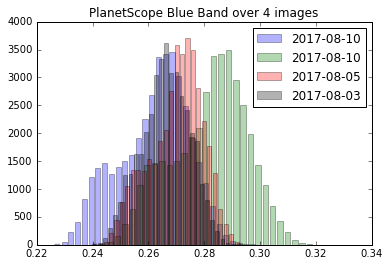

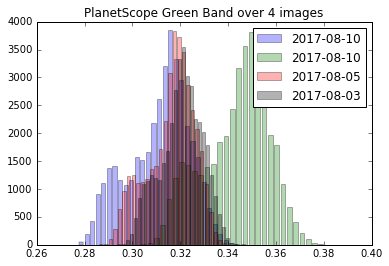

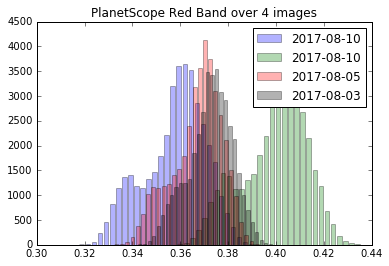

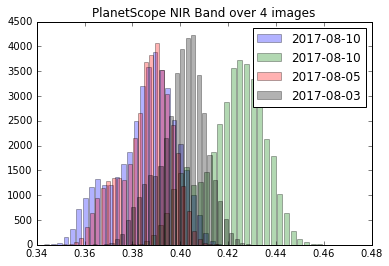

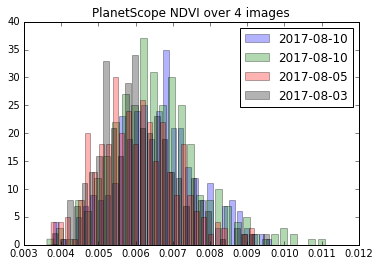

In [61]:
colors = ['b', 'g', 'r', 'k']
#colors = ['Blues', 'Greens', 'Reds', 'Greys']
bands = ['Blue', 'Green', 'Red', 'NIR']

# plot the blue channel histograms
for i in range(4):
    cur_im = pl_samples[i]['image'][0,:,:]
    plt.hist(cur_im[cur_im>0].ravel(), bins=30, alpha=0.3, normed=False, color=colors[i], rwidth=0.75, label=pl_dates[i])
    

plt.title('PlanetScope Blue Band over 4 images')
plt.legend()
plt.show()

# plot the green channel histograms
for i in range(4):
    cur_im = pl_samples[i]['image'][1,:,:]
    plt.hist(cur_im[cur_im>0].ravel(), bins=30, alpha=0.3, normed=False, color=colors[i], rwidth=0.75, label=pl_dates[i])

plt.title('PlanetScope Green Band over 4 images')
plt.legend()
plt.show()

# plot the red channel histograms
for i in range(4):
    cur_im = pl_samples[i]['image'][2,:,:]
    plt.hist(cur_im[cur_im>0].ravel(), bins=30, alpha=0.3, normed=False, color=colors[i], rwidth=0.75, label=pl_dates[i])

plt.title('PlanetScope Red Band over 4 images')
plt.legend()
plt.show()

# plot the nir channel histograms
for i in range(4):
    cur_im = pl_samples[i]['image'][3,:,:]
    plt.hist(cur_im[cur_im>0].ravel(), bins=30, alpha=0.3, normed=False, color=colors[i], rwidth=0.75, label=pl_dates[i])
    
plt.title('PlanetScope NIR Band over 4 images')
plt.legend()
plt.show()

# plot the nir channel histograms
for i in range(4):
    cur_im = ndvi_samples[i][1,:]
    plt.hist(cur_im.ravel(), bins=30, alpha=0.3, normed=False, color=colors[i], rwidth=0.75, label=pl_dates[i])
    
plt.title('PlanetScope NDVI over 4 images')
plt.legend()
plt.show()